In [81]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import atlasify as atlas
from matplotlib import style

In [82]:
# some constants we need

from cProfile import label


linestyles = ['solid', 'densely dotted', 'densely dashed', 'densely dashdotted']
markerstyles = ['o', '^', 'v', 's', 'P', 'X', '<', '>']
labelloc = [4, 4, 1, 1]
markersize = 8

# file lists
artifacts_path = "../../../../../data/gnn4itk/CF_reference_weighting/lightning_logs/"

metrics_file = "metrics.csv"
yaml_file  = "hparams.yaml"

# numbers follow from lightning_logs numbering in https://docs.google.com/spreadsheets/d/1iHRBmQXwy8UeFdAhSFhCHsTKwSY3zrCjsA4Fzpgpi1U/edit#gid=0
# standard MLP ones
mlp_reference = "version_54/" # LayerNorm and Normalization; 60 epochs
mlp_LayerNorm_noNorm= "version_60/" # 150 epochs
mlp_BatchNorm_noNorm = "version_59/" # 150 epochs

# input quantization in standard MLP; these are sweeps
mlp_input_integer    = ["version_61/", "version_62/", 
                        "version_64/", "version_65/", "version_66/", "version_67/", 
                        "version_70/", "version_71/"]
mlp_input_fractional = ["version_73/", "version_74/", "version_75/",
                        "version_76/", "version_77/", "version_78/", "version_79/",
                        "version_80/", "version_81/", "version_82/", "version_83/",
                        "version_84/", "version_85/", "version_86/", "version_87/",
                        "version_88/"]
qat_sweep = ["version_89/", "version_90/", "version_92/", "version_93/", 
             "version_94/", "version_95/", "version_96/"]

l1_sweep = ["version_100/", "version_101/", "version_99/", "version_102/",
            "version_97/", "version_98/"]

pruning_runs = ["version_103/", "version_105/"]
'''
# example run with QAT
qmlp_8bit_all = "batchnorm_no_norm_QMLP/version_3/"
# activation quantization: sweep
qmlp_activation_sweep = "batchnorm_no_norm_QMLP_sweep_act/version_"
qmlp_activation_sweep_replace_bops_dir = "batchnorm_no_norm_QMLP_sweep_act_bops/version_"
# weight sweep
qmlp_weight_sweep = "batchnorm_no_norm_QMLP_sweep_weights_new/version_"
# qmlp pruning
qmlp_prune_unstructured_L1_optimized = "batchnorm_no_norm_QMLP_optimized_pruned_L1/version_0/"
qmlp_prune_unstructured_L1_act8_w4 = "batchnorm_no_norm_QMLP_optimized_pruned_L1/version_1/"
qmlp_prune_unstructured_L1_act8_w424 = "batchnorm_no_norm_QMLP_optimized_pruned_L1/version_2/"
'''

files_mlp = [mlp_reference, mlp_LayerNorm_noNorm, mlp_BatchNorm_noNorm]
label_files_mlp = ["MLP LayerNorm w/ Normalization",
                   "MLP LayerNorm w/o Normalization",
                   "MLP BatchNorm w/o Normalization"]
label_files_qat_sweep = ["$b_{w}$ = [8, 8, 8] bit, $b_{a}$ = [8, 8, 8] bit",
                         "$b_{w}$ = [8, 4, 8] bit, $b_{a}$ = [8, 8, 8] bit",
                         "$b_{w}$ = [8, 4, 8] bit, $b_{a}$ = [8, 4, 8] bit",
                         "$b_{w}$ = [8, 4, 8] bit, $b_{a}$ = [4, 4, 4] bit",
                         "$b_{w}$ = [8, 4, 8] bit, $b_{a}$ = [6, 4, 6] bit",
                         "$b_{w}$ = [8, 2, 8] bit, $b_{a}$ = [6, 4, 6] bit",
                         "$b_{w}$ = [6, 4, 6] bit, $b_{a}$ = [6, 4, 6] bit",]
label_files_l1_sweep =  [r"L1 factor $\lambda = 1e-8$",
                         r"L1 factor $\lambda = 5e-8$",
                         r"L1 factor $\lambda = 1e-7$",
                         r"L1 factor $\lambda = 5e-7$",
                         r"L1 factor $\lambda = 1e-6$",
                         r"L1 factor $\lambda = 1e-5$",]
label_files_pruning_runs = ["Fine-tuning",
                            "Learning Rate Rewind"]
#files_mlp = [mlp_BatchNorm_noNorm]
#label_files_mlp = ["PyTorch MLP"]
'''
files_mlp_pruned = [mlp_prune_unstructured_noL1, 
                    mlp_prune_unstructured_wL1, 
                    mlp_prune_structured_wL1_dim1, 
                    mlp_prune_structured_noL1, 
                    mlp_prune_structured_wL1_dim0]      
label_files_mlp_prune = ["L1 unstructured, no L1 loss", 
                         "PyTorch MLP L1 unstructured, with L1 loss", 
                         "L1 structured (dim = 1), with L1 loss",
                         "L1 structured (dim = 1), no L1 loss",
                         "L1 structured (dim = 0), with L1 loss"]
# QMLP: quantized weights and activations, no bias!
files_qmlp_pruned = [qmlp_prune_unstructured_L1_optimized, 
                    qmlp_prune_unstructured_L1_act8_w4, 
                    qmlp_prune_unstructured_L1_act8_w424]
#label_files_qmlp_prune = ["L1 unstructured, L1 loss, w = (5,3,4), a = (7,5,6)", 
#                          "L1 unstructured, L1 loss, w = (4,4,4), a = (8,8,8)",
#                          "L1 unstructured, L1 loss, w = (4,2,4), a = (8,8,8)"]
label_files_qmlp_prune = ["pruned QAT MLP, $b_{w,[1,2-4,5]}$ = [5, 3, 4] bit, $b_{a,[1,2-3,4]}$ = [7, 5, 6] bit", 
                          "pruned QAT MLP, $b_{w,[1,2-4,5]}$ = [4, 4, 4] bit, $b_{a,[1,2-3,4]}$ = [8, 8, 8] bit",
                          "pruned QAT MLP, $b_{w,[1,2-4,5]}$ = [4, 2, 4] bit, $b_{a,[1,2-3,4]}$ = [8, 8, 8] bit"]
'''

obs = {0:"val_loss",
       1:"eff",
       2:"pur",
       3:"current_lr",
       5:"R98",
       8:"pur_98",
       10:"total_bops",
       11:"total_mem_w_bits",
       12:"total_mem_o_bits",
       13:"pruned",
       14:"epoch",
       15:"step",
       16:"train_loss"
      }
label_obs = {0:"Validation loss",
             1:"Efficiency",
             2:"Purity",
             3:"Current learning rate",
             5:"Radius for 98\% efficiency",
             8:r"Purity at 98\% edge-wise efficiency",
             10:"BOPs per cluster/event",
             11:"Memory bits (weights)",
             12:"Memory bits (output, per cluster)",
             13:"Number of pruning steps",
             14:"Epoch",
             15:"Training step",
             16:"Training loss"
      }

reference_label = "PyTorch reference"
reference_20_label = "PyTorch reference (20 epochs)"



In [83]:
def run_atlas(more_subtext=""):
      atlas.atlasify("Simulation Internal",
                     subtext="Graph construction w/ Metric Learning" + "\n" + 
                     r"$\sqrt{s}=14$TeV, $t \bar{t}$, $\langle \mu \rangle = 200$, primaries $t \bar{t}$ and soft interactions"+ "\n" +
                     more_subtext)
      
def filter_nan(arr): 
     """The way csv file is created for qnn networks, contain some 'nans'
    Therefore I created a function to remove 'nan' from the csv file array"""
     index =np.where( np.isnan(arr)==0)
     filter_arr = arr[index]
     return filter_arr

def return_purities(file_list, max_or_last, max_epochs = 0):
    labels = ['pur_98'] # ['pur_95', 'pur_98', 'pur_99']
    pur98 = []
    purs = [pur98]
    for current_file in file_list:
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
            if(max_epochs > 0):
                metrics= metrics.drop(metrics[metrics['epoch'] > max_epochs].index)
        for purity, label in zip (purs, labels):
            if(max_or_last == "max"): 
                purity.append(np.amax(filter_nan(np.array(metrics[label]))))
            else:
                purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
    return purs

def return_initial_bops(file_w_bops):
    label = ['total_bops']
    csv_path = f"{file_w_bops}{metrics_file}"
    with open(csv_path) as file:
        metrics = pd.read_csv(file)
    return(filter_nan(np.array(metrics[label]))[0]) # taking first value

def purities_vs_bops(current_file, max_or_last, max_epochs = 0):
    labels = ['pur_98', 'total_bops'] # ['pur_95', 'pur_98', 'pur_99', 'total_bops'] 
    pur98 = []
    bops  = []
    purs = [pur98, bops]
    csv_path = f"{artifacts_path}{current_file}{metrics_file}"
    with open(csv_path) as file:            
        metrics = pd.read_csv(file)
        if(max_epochs > 0):
            metrics= metrics.drop(metrics[metrics['epoch'] > max_epochs].index)
        index_list = []
        last_pruned = 0
        max_index = 0
        max_indices = []
        try:
            epoch_list = metrics[metrics["pruned"]>0]
            index_list = np.array(epoch_list["epoch"])
            print(index_list) 
            pruned_array = filter_nan(np.array(metrics["pruned"]))
            print(pruned_array)
            pruned_array = 1-(0.8**pruned_array)
            print(pruned_array)
        except:
            pass
            #print("no pruned column")
        for purity, label in zip (purs, labels):
            if index_list == []:
                if(max_or_last == "max"): 
                    if(label == 'pur_98'):
                        max_index = np.argmax(filter_nan(np.array(metrics[label])))-1 # BOPS are only calculated after 1 epoch!
                        purity.append(np.amax(filter_nan(np.array(metrics[label])))) # for BOPS make sure to take index of max purity!
                    if(label == 'total_bops'):
                        purity.append(filter_nan(np.array(metrics[label]))[max_index])
                else:
                    purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
            else:
                k = 0
                last_pruned = 0
                for index in index_list :
                    sliced_metrics = metrics[metrics["epoch"] > last_pruned]   
                    sliced_metrics = sliced_metrics[sliced_metrics["epoch"] <= index]
                    #print(last_pruned, index)
                    #print(sliced_metrics)
                    last_pruned = index
                    if(max_or_last == "max"): 
                        if(label == 'pur_98'):
                            max_index = np.argmax(filter_nan(np.array(sliced_metrics[label]))) 
                            if(last_pruned == 0):
                                max_index = max_index - 1 # BOPS are only calculated after 1 epoch! 
                            max_indices.append(max_index)
                            purity.append(np.amax(filter_nan(np.array(sliced_metrics[label])))) # for BOPS make sure to take index of max purity!
                        if(label == 'total_bops'):
                            purity.append(filter_nan(np.array(sliced_metrics[label]))[max_indices[k]])
                            k = k+1
                        #print(max_indices)
                    else:
                        purity.append(filter_nan(np.array(metrics[label]))[index]) # taking last value: index -1
                        
    return purs

def purities_bops_vs_config(sweep_dir, config_key, max_or_last, skip=[]):
    labels = ['pur_98', 'total_bops'] #     labels = ['pur_95', 'pur_98', 'pur_99', 'total_bops']
    pur98 = []
    bops = []
    config = []
    purs = [pur98, bops]
    for current_file in sweep_dir:
        #if i in skip:
        #    print(f"skip {i}")
        #    continue
        yaml_path = f"{artifacts_path}{current_file}{yaml_file}"
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
        for purity, label in zip (purs, labels):
            if(max_or_last == "max"): 
                if(label == 'pur_98'):
                    max_index = np.argmax(filter_nan(np.array(metrics[label])))-1 # BOPS are only calculated after 1 epoch!
                    purity.append(np.amax(filter_nan(np.array(metrics[label])))) # for BOPS make sure to take index of max purity!
                if(label == 'total_bops'):
                    purity.append(filter_nan(np.array(metrics[label]))[max_index])
            else:
                purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
        with open(yaml_path) as file:
            all_configs = yaml.load(file, Loader=yaml.FullLoader)
            config.append(all_configs[config_key])
                #print(f"config_key: {config_key} all_configs[config_key]: {all_configs[config_key]}")
    purs.append(config)
    return purs


In [84]:
reference_purities = return_purities(files_mlp, "last")
#print(reference_purities)
reference_purities = return_purities(files_mlp, "max")
#print(reference_purities)

ref_vs_bops = []
ref_vs_bops_20 = []
for file in files_mlp:
    ref_vs_bops.append(purities_vs_bops(file, "max"))
    ref_vs_bops_20.append(purities_vs_bops(file, "max", 20))
    
purity_labels = [label_obs[8]]  # purity at 98 % efficiency
reference = ref_vs_bops[2]  # BatchNorm no Norm
reference_20 = ref_vs_bops_20[2]    # BatchNorm no Norm

pur_vs_int = purities_bops_vs_config(mlp_input_integer, "integer_part", "max")
pur_vs_fra = purities_bops_vs_config(mlp_input_fractional, "fractional_part", "max")

#print(pur_vs_int)
#print(pur_vs_fra)

qat_purities_vs_bops = []
for file in qat_sweep:
    qat_purities_vs_bops.append(purities_vs_bops(file, "max"))

#print(qat_purities_vs_bops)

l1_purities_vs_bops = []
for file in l1_sweep:
    l1_purities_vs_bops.append(purities_vs_bops(file, "max"))

#print(l1_purities_vs_bops)

print("here I am!")
pruned_purities_vs_bops = []
for file in pruning_runs:
    pruned_purities_vs_bops.append(purities_vs_bops(file, "max"))

print(pruned_purities_vs_bops)
''' 
pur_vs_bops = []
for file in files_mlp_pruned:
    pur_vs_bops.append(purities_vs_bops(file))
'''
#print(pur_vs_bops[0][0]) #[file][metric]
#print(ref_vs_bops)
'''
example_pur_vs_bops = purities_vs_bops(qmlp_8bit_all)

pur_vs_int = purities_bops_vs_config(mlp_input_integer, 8, "integer_part")
pur_vs_fra = purities_bops_vs_config(mlp_input_fractional, 26, "fractional_part", skip=[9,22])
pur_qmlp_activation_sweep = purities_bops_vs_configs(qmlp_activation_sweep, 
                                                 343, 
                                                 ["activation_bit_width_input", 
                                                  "activation_bit_width_hidden",
                                                  "activation_bit_width_output"], 
                                                  skip=[])
print(pur_qmlp_activation_sweep)

pur_qmlp_weight_sweep = purities_bops_vs_configs(qmlp_weight_sweep, 
                                                 21, 
                                                 ["weight_bit_width_input", 
                                                  "weight_bit_width_hidden",
                                                  "weight_bit_width_output"], 
                                                  skip=[])


print(pur_vs_int)
print(pur_vs_fra)


qmlp_pur_vs_bops = []
for file in files_qmlp_pruned:
    qmlp_pur_vs_bops.append(purities_vs_bops(file))
#print(pur_vs_bops[0][0]) #[file][metric]
print(qmlp_pur_vs_bops)
'''

here I am!
[149 165 221 249 265 280 298 309 320 331 348 364 375]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
[0.2        0.36       0.488      0.5904     0.67232    0.737856
 0.7902848  0.83222784 0.86578227 0.89262582 0.91410065 0.93128052
 0.94502442]
[149 299 449 599 749 899]
[1. 2. 3. 4. 5. 6.]
[0.2      0.36     0.488    0.5904   0.67232  0.737856]
[[[0.0036050106864422, 0.0035521052777767, 0.0036046339664608, 0.0036372079048305, 0.0036341347731649, 0.0036566515918821, 0.0036193742416799, 0.0035890021827071, 0.0035794721916317, 0.0035015495959669, 0.0031046932563185, 0.0023548079188913, 0.0014351970748975], [3062532.0, 3177296.0, 3224544.0, 3241976.0, 3245696.0, 3245560.0, 3059260.0, 2750408.0, 2448432.0, 2128808.0, 1710532.0, 1370324.0, 1101488.0]], [[0.0036151031963527, 0.0036909717600792, 0.0037038126029074, 0.0036721059586852, 0.0037149188574403, 0.0036939531564712], [2989280.0, 2496772.0, 2231488.0, 2074012.0, 1949284.0, 1837972.0]]]


/tmp/ipykernel_1864468/2554925243.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if index_list == []:
/tmp/ipykernel_1864468/2554925243.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if index_list == []:


'\nexample_pur_vs_bops = purities_vs_bops(qmlp_8bit_all)\n\npur_vs_int = purities_bops_vs_config(mlp_input_integer, 8, "integer_part")\npur_vs_fra = purities_bops_vs_config(mlp_input_fractional, 26, "fractional_part", skip=[9,22])\npur_qmlp_activation_sweep = purities_bops_vs_configs(qmlp_activation_sweep, \n                                                 343, \n                                                 ["activation_bit_width_input", \n                                                  "activation_bit_width_hidden",\n                                                  "activation_bit_width_output"], \n                                                  skip=[])\nprint(pur_qmlp_activation_sweep)\n\npur_qmlp_weight_sweep = purities_bops_vs_configs(qmlp_weight_sweep, \n                                                 21, \n                                                 ["weight_bit_width_input", \n                                                  "weight_bit_width_hidden",\n         

In [85]:
plt.rcParams['savefig.dpi'] = 800
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['text.usetex'] = True

x_min = 1e4
x_max = 1e9
y_min = 0
y_max = 0.005

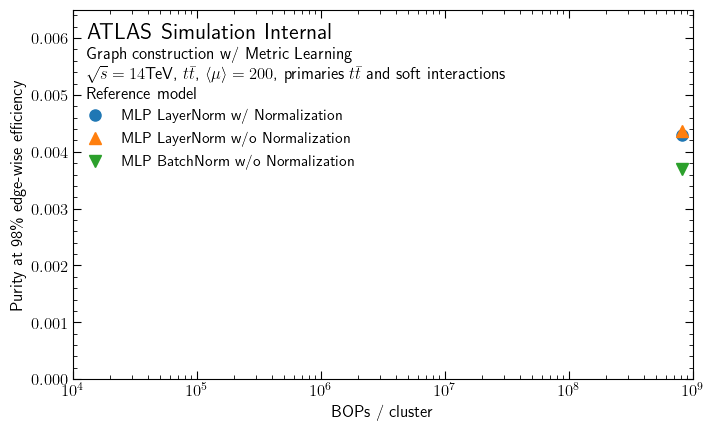

In [86]:
png_index = 98
# references only
fig = plt.figure(figsize=(8,4.8))
ax = plt.subplot()
#ax.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax.set_ylabel(purity_labels[0])
ax.set_xscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_xlabel("BOPs / cluster")

index = 0
for pur_file, graph_label in zip(ref_vs_bops, label_files_mlp):
    for lab, pur, ref in zip (purity_labels, pur_file, reference):
        ax.plot(pur_file[1],pur, label = graph_label, alpha=1, marker=markerstyles[index], markersize = markersize, linestyle="none") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=(0,0.55))
        index = index + 1
run_atlas("Reference model")
plt.savefig(f"{artifacts_path}plots/reference_{png_index}.png")

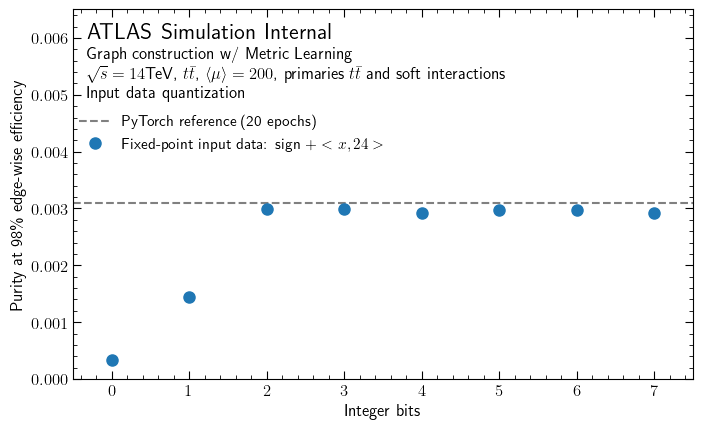

In [87]:
png_index = 98
for lab, pur, ref in zip (purity_labels, pur_vs_int, reference_20):
    fig = plt.figure(figsize=(8,4.8))
    ax = plt.subplot()
    ax.axline((1e8,ref[0]),(1e9,ref[0]),linestyle = 'dashed', color = "gray", label = reference_20_label)
    ax.set_ylabel(lab)
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(-0.5,7.5)
    ax.set_xlabel("Integer bits")
    ax.plot(pur_vs_int[2],pur, label = r"Fixed-point input data: sign + $<x,24>$", alpha=1, linestyle="None", marker = "o", markersize= markersize) ##plotting )
    ax.legend(loc=(0,0.6))
    run_atlas("Input data quantization")
    plt.savefig(f"{artifacts_path}plots/integer_{png_index}.png")


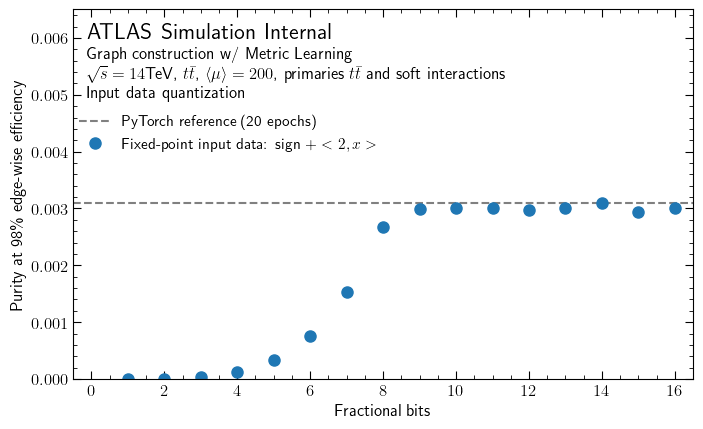

In [88]:
png_index = 98
for lab, pur, ref in zip (purity_labels, pur_vs_fra, reference_20):
    fig = plt.figure(figsize=(8,4.8))
    ax = plt.subplot()
    ax.axline((1e8,ref[0]),(1e9,ref[0]),linestyle = 'dashed', color = "gray", label = reference_20_label)
    ax.set_ylabel(lab)
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(-0.5,16.5)
    ax.set_xlabel("Fractional bits")
    ax.plot(pur_vs_fra[2],pur, label = r"Fixed-point input data: sign + $<2,x>$", alpha=1, linestyle="None", marker = "o", markersize= markersize) ##plotting )
    ax.legend(loc=(0,0.6))
    run_atlas("Input data quantization")
    plt.savefig(f"{artifacts_path}plots/fractional_{png_index}.png")



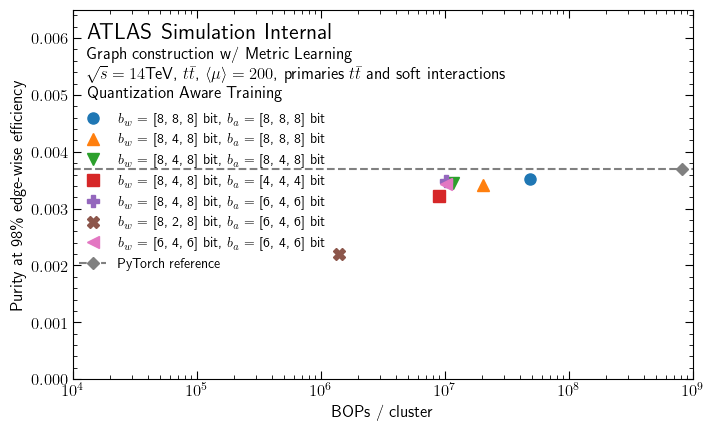

In [89]:
png_index = 98
# references only
fig = plt.figure(figsize=(8,4.8))
ax = plt.subplot()
ax.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax.set_ylabel(purity_labels[0])
ax.set_xscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_xlabel("BOPs / cluster")
index = 0
for pur_file, graph_label in zip(qat_purities_vs_bops, label_files_qat_sweep):
    for lab, pur in zip (purity_labels, pur_file):
        ax.plot(pur_file[1],pur, label = graph_label, alpha=1, marker=markerstyles[index], markersize = markersize, linestyle="none") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=4, fontsize=8)
        index = index + 1
ax.plot(reference[1][0], reference[0][0], label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
ax.legend(loc=(0,0.28), fontsize=10)
run_atlas("Quantization Aware Training")
plt.savefig(f"{artifacts_path}plots/qat_{png_index}.png")

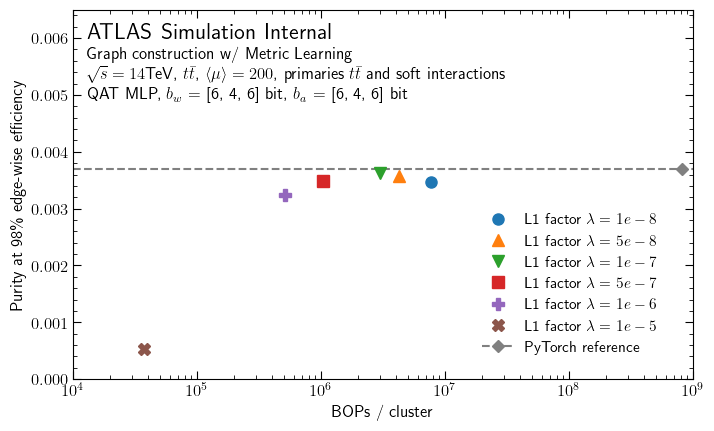

In [90]:
png_index = 98
# references only
fig = plt.figure(figsize=(8,4.8))
ax = plt.subplot()
ax.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax.set_ylabel(purity_labels[0])
ax.set_xscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_xlabel("BOPs / cluster")
index = 0
for pur_file, graph_label in zip(l1_purities_vs_bops, label_files_l1_sweep):
    for lab, pur in zip (purity_labels, pur_file):
        ax.plot(pur_file[1],pur, label = graph_label, alpha=1, marker=markerstyles[index], markersize = markersize, linestyle="none") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=4, fontsize=8)
        index = index + 1
ax.plot(reference[1][0], reference[0][0], label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
ax.legend(loc=(0.65,0.05))
run_atlas("QAT MLP, $b_{w}$ = [6, 4, 6] bit, $b_{a}$ = [6, 4, 6] bit")
plt.savefig(f"{artifacts_path}plots/l1_{png_index}.png")

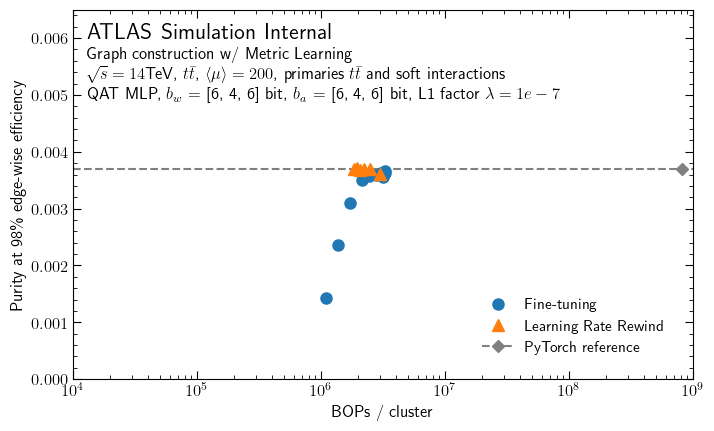

In [91]:
png_index = 98
# references only
fig = plt.figure(figsize=(8,4.8))
ax = plt.subplot()
ax.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax.set_ylabel(purity_labels[0])
ax.set_xscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.set_xlabel("BOPs / cluster")
index = 0
for pur_file, graph_label in zip(pruned_purities_vs_bops, label_files_pruning_runs):
    for lab, pur in zip (purity_labels, pur_file):
        ax.plot(pur_file[1],pur, label = graph_label, alpha=1, marker=markerstyles[index], markersize = markersize, linestyle="none") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=4, fontsize=8)
        index = index + 1
ax.plot(reference[1][0], reference[0][0], label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
ax.legend(loc=(0.65,0.05))
run_atlas("QAT MLP, $b_{w}$ = [6, 4, 6] bit, $b_{a}$ = [6, 4, 6] bit, L1 factor $\lambda = 1e-7$")
plt.savefig(f"{artifacts_path}plots/pruning_{png_index}.png")

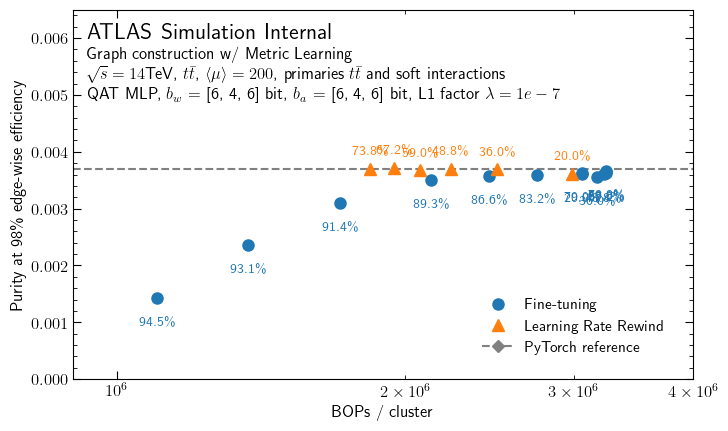

In [92]:
from turtle import color


png_index = 98
# references only
fig = plt.figure(figsize=(8,4.8))
ax = plt.subplot()
ax.axline((1e8,reference[0][0]),(1e9,reference[0][0]),linestyle = 'dashed', color = "gray")
ax.set_ylabel(purity_labels[0])
ax.set_xscale('log')
ax.set_ylim(y_min,y_max)
x_min = 9e5
x_max = 4e6
ax.set_xlim(x_min,x_max)
ax.set_xlabel("BOPs / cluster")
index = 0
for pur_file, graph_label in zip(pruned_purities_vs_bops, label_files_pruning_runs):
    for lab, pur in zip (purity_labels, pur_file):
        ax.plot(pur_file[1],pur, label = graph_label, alpha=1, marker=markerstyles[index], markersize = markersize, linestyle="none") #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=4, fontsize=8)
        index = index + 1
        fp_index = 0
        for(x,y) in zip(pur_file[1],pur):
            fp_index = fp_index + 1
            f_p = (1-0.8**fp_index)*100
            if(index == 1):
                color = "tab:blue"
                xytext = (0,-20)
            else:
                color = "tab:orange"
                xytext = (0,10)
            plt.annotate(f"{f_p:.1f}\%", 
                         (x,y),
                         textcoords="offset points",
                         xytext=xytext,
                         ha='center',
                         color = color)
ax.plot(reference[1][0], reference[0][0], label = reference_label, alpha=1, marker = "D", linestyle="dashed", color = "gray")
ax.legend(loc=(0.65,0.05))
run_atlas("QAT MLP, $b_{w}$ = [6, 4, 6] bit, $b_{a}$ = [6, 4, 6] bit, L1 factor $\lambda = 1e-7$")
plt.savefig(f"{artifacts_path}plots/pruning_{png_index}_zoom.png")